# Introduction

**Last edited**: 2017-11-04 14:19:48 

[nbviewer](http://nbviewer.jupyter.org/github/nuclth/Kaggle_Digit_Recognizer/blob/master/Neural_Network_Beginner.ipynb)

This is a notebook to classify handwritten digits in the MNIST data set using a simple neural network. Most of the code and implementation are borrowed from Chapters 1 and 2 of Michael Nielsen's [book](http://neuralnetworksanddeeplearning.com/) on neural networks and deep learning as well as the code hosted on his [github page](https://github.com/mnielsen/neural-networks-and-deep-learning) (note that it is all written in python 2). Also useful is a python 3 implementation of the same code by [Michał Dobrzanski](https://github.com/MichalDanielDobrzanski/DeepLearningPython35). The actual implementation code for this notebook is hidden in the file, `network.py` in the `src` subdirectory. The MNIST data we use is downloaded from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

This problem is classified as a supervised classification problem. Supervised because we are inputting some subset of the MNIST data set to guide our model, and classification because we ultimately want to decide which digit the image is referring to in the range 0 - 9 inclusive. Each image consists of 28 pixels by 28 pixel, 784 pixels in total, with each pixel taking a possible value of 0 to 255 (0 = white, 255 = black, gray for everything in between).

First let's import the relevant libraries:

<br>

In [1]:
## import libraries
# standard libraries
import sys
import random
import gc

# third party libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn import svm

# import network module
import src.network as network

<br>
Next we import the data that we previously downloaded. Note that the training data has one column with the image label and then 784 columns with a number between 0 and 255 to denote pixel activation. Our test set is similar only it is missing the label column as this is what we are trying to predict.

<br>

In [4]:
training_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [3]:
training_data.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<br>
Let's take a quick look to see what the images look like. We arbitrarily choose the second image in the training set (index from zero, so value 1 is the second image). The image is printed with 28 pixels to a row so as to make the digit in the image obvious. 

<br>

In [6]:
network.print_image (training_data, 1)



  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0  18  30 137 137 192  86  72   1   0   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0   0  13  86 250 254 254 254 254 217 246 151  32   0   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0  16 179 254 254 254 254 254 254 254 254 254 231  54  15   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0  72 254 254 254 254 254 254 254 254 254 254 254 254 104   0   0   0   0   0   0   0 

  0   0   0   0   0   0  61 191 254 254 254 254 254 109  83 199 254 254 254 254 243  8

<br>
It's pretty obvious that this image should correspond to a zero, but let's check the label itself just to be sure,

<br>

In [10]:
# .iloc[1,0] chooses the second row (second image) and 
# first column (label) of the training dataset.
print ('Image Label {}'.format(training_data.iloc[1,0]))

Image Label 0


<br>
Bingo.

<br>

## Data Wrangling

<br>
Now let's actually see how many images we're working with in each set and start manipulating the data.

<br>

In [5]:
training_data.info() ; print('\n')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


<br>
We see that our training set contains 42,000 images while our test set has 28,000 images. Note also that as expected, we have the correct number of columns for each (785 and 784 respectively).

Let's separate our training data into a training set and a validation set. The training set will be used to fit our model and then we'll validate the model with the remaining data in the validation set. For simplicity, we fit using the first 40,000 images in the training set and validate against the last 2,000 entries. For ease of working with the data, we pull it from our dataframe into a numpy array and then format it using the function `format_data`. This is done for our training and validation set (for more details on the output format, consult the function defined in `network.py`). 

For our test data, we follow the same procedure but perform the formatting in the cell below and obviously do not have a label for each image. Note that the code *requires* a shape of (784,1) rather than (784,) for correct performance of numpy routines. Also note that we normalize the pixel values to be in the range $[0,1]$ rather than $[0,255]$.

<br>

In [21]:
# create data sets
train_ar = np.array(training_data.iloc[:40000])
valid_ar = np.array(training_data.iloc[40000:42000])
test_ar  = np.array(test_data)

# format training and validation set
train_list = network.format_data (train_ar)
valid_list = network.format_data (valid_ar)
train_list = list(train_list)
valid_list = list(valid_list)

# format the test data
test_list = [np.reshape(x, (784,1))/255 for x in test_ar]

## Validation Pass

<br>
Now let's create a neural network. We call the class name `Network` and give our network one hidden layer with 30 nodes. The choice of one hidden layer and the exact number of nodes is arbitrary at this point. Note that we also have an initial layer of 784 nodes (one node per pixel) and an output layer of 10 nodes, one for each possible digit $[0,9]$. Note that for this choice of layers and nodes, we have two weight matrices of dimensions (30, 784) and (10, 30). Our biases on each layer are vectors of dimension (30, 1) and (10, 1). 

We then perform stochastic gradient descent on the network by calling the class function `SGD`. The idea is that this routine calculates the derivatives of a defined cost function as a function of the weights and biases. We tune the weights and biases so as to minimize this cost function, here defined as the difference between the output on the last layer of 10 nodes and the correct result. For example, suppose our network for image $i$ with label 2 gives the output,

$$\text{approx}_i = [0, 0.2, 0.7, 0, 0.1, 0, 0, 0, 0, 0.3] \enspace .$$

Our cost function for this output is then given as the difference between it and the exact output ,

$$\text{exact}_i = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] \enspace ,$$

$$\text{cost}_i = \text{approx}_i - \text{exact}_i \enspace ,$$

where only the 3rd entry changes as that corresponds to digit 2 (again indexing starts at 0).



The gradient descent is costly to calculate for all images, so we sample this stochastically with some subset of images. The gradient is also multiplied by some number (called the learning parameter) to give greater or lesser importance to it. A small learning parameter means we move more slowly (but surely) through this space while a bigger parameter lets us move quicker (but perhaps less accurately). This whole process is then repeated for several 'epochs' so as to train the network and optimize the biases/weights. After each epoch, we output the number of images in the validation set that have been correctly classified. For much more detail, again see the book by Michael Nielsen (chapters 1 and 2). 

The `SGD` function is called with 30 epochs of training, 10 images chosen for the gradient averaging, and a learning parameter of 3. At this point, these choices are arbitrary and are not necessarily optimized. The results of each epoch of training are stored in `eval_list` and the ultimate output after all epochs are finished are the trained biases and weights of the network.

<br>

In [12]:
# list values denotes number of nodes in each layer
net = network.Network([784, 30, 10])

# create blank list to store results
eval_list = []

# call SGD function and store final biases and weights
(biases, weights) = net.SGD(train_list, 30, 10, 3.0, test_data = valid_list, store_eval = eval_list)

NameError: name 'train_list' is not defined

We can plot his information to see the rapid improvement with each epoch of training. After a few epochs, it seems that the network saturates around a given accuracy. 

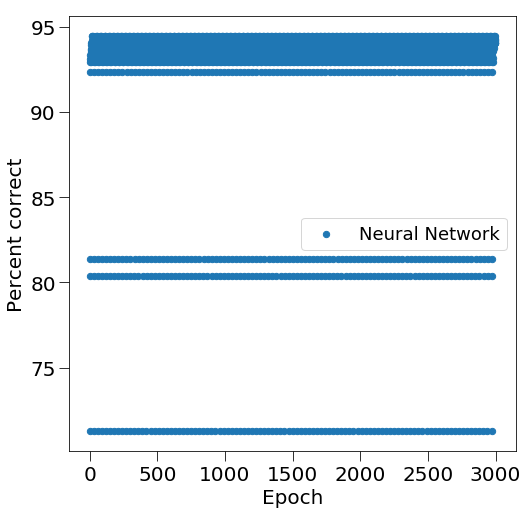

In [19]:
# import plotting/visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

# set custom plotting values
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20 
mpl.rcParams['ytick.labelsize'] = 20 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['lines.markersize'] = 1000
mpl.rcParams['legend.fontsize'] = 18


epoch_list = [a for a in range (0,len(eval_list))]

# plot the function and data
plt.scatter(epoch_list, eval_list, s=40, label="Neural Network")
plt.xlabel ("Epoch")
plt.ylabel ("Correct ratio")
plt.legend()
plt.show()

## Neural Network Testing

In [9]:
def sigmoid(z):
    return (1.0/(1.0 + np.exp(-z)))

def feedforward(a, biases, weights):
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

In [10]:
imageid = pd.Series(range(1,len(test_list)+1))

In [11]:
predictions_test = [np.argmax(feedforward(image, biases, weights)) for image in test_list]

In [12]:
output = pd.DataFrame({'ImageId' : imageid, 'Label' : predictions_test})

Let's make sure everything looks ok and that we built our dataframe correctly.

In [13]:
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [14]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
ImageId    28000 non-null int32
Label      28000 non-null int64
dtypes: int32(1), int64(1)
memory usage: 328.2 KB


Looks good so let's output to csv and submit to kaggle.

In [15]:
output.to_csv('predictions_digits.csv', index=False)

Submission to kaggle then gives an accuracy score of around 95% (94.514% for the one I submitted).

## SVM Baseline (under construction, move to new notebook)

Let's run a support vector machine baseline to see where we sit (this may take several minutes to execute)

Somewhere in the low 90% area. Not too shabby but let's see if we can do better with a neural network.